<h1> Imports </h1>

In [1]:
from read_data import read_dataset_1, translate_1, read_dataset_3, translate_3
from models import SimulationEnvironment
from optimizer import BaseGA
from visualize import reformat_result, visualize

<h1>Parameters</h1>


In [2]:
# Parameters
max_generations = 20
earliest_time_slot = 200
last_time_slot = 5000
population_size = 10
offspring_amount = 20

order_amount = 10

<h1>Input Data</h1>
<h4>Choose 1 of the following</h4>

Dataset 1 (Job Shop Scheduling)

In [10]:
input, orders, instance = read_dataset_1(use_instance=2, order_amount=order_amount, earliest_time=earliest_time_slot, last_time=last_time_slot)
recipes, workstations, resources, tasks, orders_model = translate_1(instance, orders)

Dataset 3, Resource Constrained (Job Shop Scheduling)

In [9]:
input, orders, instance = read_dataset_3(order_amount=order_amount, earliest_time=earliest_time_slot, last_time=last_time_slot)
recipes, workstations, resources, tasks, orders_model = translate_3(instance, n_workstations=10, generated_orders=orders) # for dataset 3, the amount of available machines has to be declared (not included with the data)

<h1> Simulation Environment Setup </h1>

In [11]:
env = SimulationEnvironment(workstations, tasks, resources, recipes)

<h1> Optimizer Configurations </h1>

Config 1 - Test with One Point Crossover

Current generation: 0, Current Best: 294, not feasible
New best individual found!
Current generation: 1, Current Best: 292, not feasible
New best individual found!
Current generation: 2, Current Best: 288, not feasible
New best individual found!
Current generation: 3, Current Best: 287, not feasible
New best individual found!
Current generation: 4, Current Best: 284, not feasible
Current generation: 5, Current Best: 284, not feasible
New best individual found!
Current generation: 6, Current Best: 283, not feasible
New best individual found!
Current generation: 7, Current Best: 282, not feasible
New best individual found!
Current generation: 8, Current Best: 281, not feasible
Current generation: 9, Current Best: 281, not feasible
New best individual found!
Current generation: 10, Current Best: 279, not feasible
New best individual found!
Current generation: 11, Current Best: 278, not feasible
New best individual found!
Current generation: 12, Current Best: 277, not feasible
Current gene

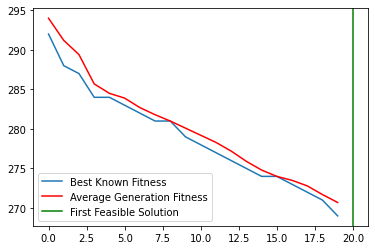

In [13]:
optimizer = BaseGA(env)
optimizer.set_minimize()
# optional (in this case, all options given are the default option, if the configuration step is skipped)
optimizer.configure('tardiness', 'onepointcrossover', 'roulettewheel', 'randomize')
# choose an input generator (optional) -> decides how the data gets converted into the optimizer format
# optimizer.set_input_generator('SameLengthAlternativesGenerator')
# all parameters after offspring_amount are optional (in this case -> verbose=True)
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
workstation_assignments = reformat_result(result, orders, workstations, recipes, tasks)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

Config 2 - Test with Two Point Crossover

Current generation: 0, Current Best: 292, not feasible
New best individual found!
Current generation: 1, Current Best: 287, not feasible
New best individual found!
Current generation: 2, Current Best: 286, not feasible
Current generation: 3, Current Best: 285, not feasible
New best individual found!
Current generation: 4, Current Best: 280, not feasible
Current generation: 5, Current Best: 280, not feasible
New best individual found!
Current generation: 6, Current Best: 279, not feasible
New best individual found!
Current generation: 7, Current Best: 279, not feasible
Current generation: 8, Current Best: 279, not feasible
New best individual found!
Current generation: 9, Current Best: 278, not feasible
New best individual found!
Current generation: 10, Current Best: 277, not feasible
Current generation: 11, Current Best: 277, not feasible
New best individual found!
Current generation: 12, Current Best: 276, not feasible
Current generation: 13, Current Best: 276, not feasible
New best i

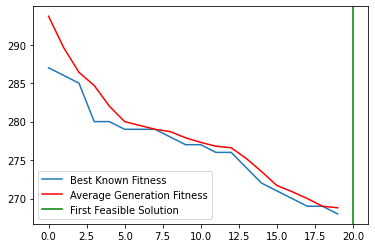

In [14]:
optimizer = BaseGA(env)
optimizer.set_minimize()
# optional (in this case, all options given are the default option, if the configuration step is skipped)
optimizer.configure('tardiness', 'twopointcrossover', 'roulettewheel', 'randomize')
# choose an input generator (optional) -> decides how the data gets converted into the optimizer format
#optimizer.set_input_generator('SameLengthAlternativesGenerator')
# all parameters after offspring_amount are optional (in this case -> verbose=True)
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
workstation_assignments = reformat_result(result, orders, workstations, recipes, tasks)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

Config 3 - Only valid mutations for time slots

Current generation: 0, Current Best: 210, not feasible
Current generation: 1, Current Best: 210, not feasible
Current generation: 2, Current Best: 210, not feasible
Current generation: 3, Current Best: 210, not feasible
Current generation: 4, Current Best: 210, not feasible
Current generation: 5, Current Best: 210, not feasible
Current generation: 6, Current Best: 210, not feasible
Current generation: 7, Current Best: 210, not feasible
Current generation: 8, Current Best: 210, not feasible
Current generation: 9, Current Best: 210, not feasible
Current generation: 10, Current Best: 210, not feasible
Current generation: 11, Current Best: 210, not feasible
Current generation: 12, Current Best: 210, not feasible
Current generation: 13, Current Best: 210, not feasible
Current generation: 14, Current Best: 210, not feasible
Current generation: 15, Current Best: 210, not feasible
Current generation: 16, Current Best: 210, not feasible
Current generation: 17, Current Best: 210, not feasible
Cu

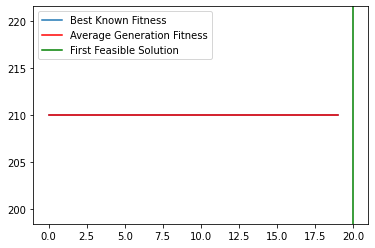

In [15]:
optimizer = BaseGA(env)
optimizer.configure('tardiness', 'twopointcrossover', 'roulettewheel', 'onlyfeasibletimeslot')
last_time_slot = 0
for order in orders:
    if order[1] > last_time_slot:
        last_time_slot = order[1]
# all parameters after offspring_amount are optional (in this case -> verbose=True)
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
workstation_assignments = reformat_result(result, orders, workstations, recipes, tasks)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)